<a href="https://colab.research.google.com/github/Nisha40108/ParkNaviGo/blob/main/Class_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [240]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [241]:
!pip install tensorflow==2.12

### <b>Importing All the libraries</b>

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import zipfile
import io
import os
import shutil
import pathlib
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from io import BytesIO
from zipfile import ZipFile

In [243]:
#import shutil
#import os

#zip_file_path = '/content/sample_data/Train_data'
#extracted_folder_path = '/content/sample_data/KSU_Parking_data'

# Unzip the file
#shutil.unpack_archive(zip_file_path, extracted_folder_path, 'zip')

In [244]:
import os
import shutil
import pathlib
import random

original_dir = pathlib.Path("/content/sample_data/Train_Data")
new_base_dir = pathlib.Path("/content/sample_data/KSU_Parking_data")

def make_subset(subset_name, start_index, end_index):
    indices = list(range(start_index + 1, min(end_index + 1, 250)))
    random.shuffle(indices)  # Shuffle the indices randomly

    for category in ("empty", "occupied"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        fnames = [f"{category} {i}.png" for i in indices]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# 70% for training
make_subset("train_data_2", start_index=0, end_index=125)

# 15% for validation
make_subset("validation_data_2", start_index=126, end_index=176)

# 15% for testing
make_subset("test_data_2", start_index=177, end_index=227)

### <b>Importing the Empty and Non empty dataset </b>

In [245]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/sample_data/Train_Data")
new_base_dir = pathlib.Path("/content/sample_data/KSU_Parking_data")

def make_subset(subset_name, start_index, end_index):
    for category in ("empty", "occupied"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok = True)
        fnames = [f"{category} {i}.png" for i in range(start_index + 1, min(end_index + 1,250))]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# 70% for training
make_subset("train_data_1", start_index =0, end_index= 125)

# 15% for validation
make_subset("validation_data_1", start_index= 126, end_index= 176)

# 15% for testing
make_subset("test_data_1", start_index=177, end_index=227)

### <b>Creating Train, validation and Test dataset in </b>

In [246]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train_data_2",
    image_size=(224, 224),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_data_2",
    image_size=(224, 224),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_data_2",
    image_size=(224, 224),
    batch_size=32)

Found 250 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


### <b>Checking for the shape and label for image </b>

In [247]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


### <b>Display the first 9 images </b>

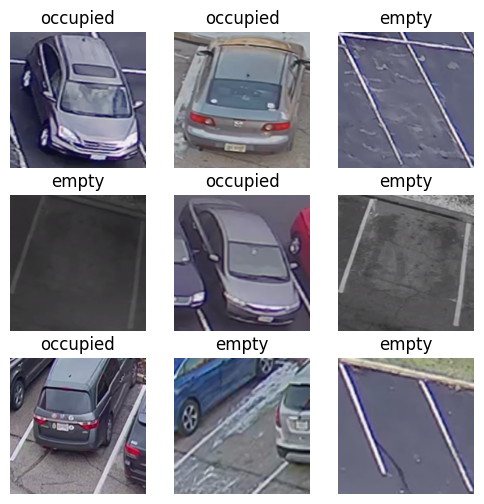

In [248]:
class_names = train_dataset.class_names

plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers**

In [249]:
#Building the model
#Instantiating a small convnet for dogs vs. cats classification
#**

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

In [250]:
model.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_43 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_225 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_182 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_226 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 54, 54, 64)       0         
 ng2D)                                                    

### **Training The model**

In [251]:
# Compilimg the results of the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting/Running the Model
Model_1 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/50
8/8 [==============================] - 3s 105ms/step - loss: 0.6803 - accuracy: 0.5680 - val_loss: 0.6499 - val_accuracy: 0.7200
Epoch 2/50
8/8 [==============================] - 1s 78ms/step - loss: 0.5454 - accuracy: 0.7440 - val_loss: 0.3977 - val_accuracy: 0.8000
Epoch 3/50
8/8 [==============================] - 1s 78ms/step - loss: 0.2431 - accuracy: 0.8760 - val_loss: 0.3794 - val_accuracy: 0.8800
Epoch 4/50
8/8 [==============================] - 1s 69ms/step - loss: 0.1636 - accuracy: 0.9440 - val_loss: 0.5960 - val_accuracy: 0.8900
Epoch 5/50
8/8 [==============================] - 1s 76ms/step - loss: 0.1080 - accuracy: 0.9600 - val_loss: 0.2985 - val_accuracy: 0.9200
Epoch 6/50
8/8 [==============================] - 1s 68ms/step - loss: 0.0619 - accuracy: 0.9720 - val_loss: 0.6302 - val_accuracy: 0.8700
Epoch 7/50
8/8 [==============================] - 1s 67ms/step - loss: 0.0649 - accuracy: 0.9800 - val_loss: 0.4118 - val_accuracy: 0.8900
Epoch 8/50
8/8 [==========

### **Looking at the visuals of the Training and Validation Accuracy/Loss**

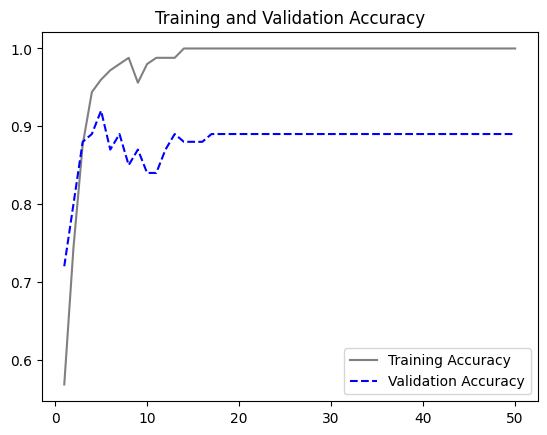

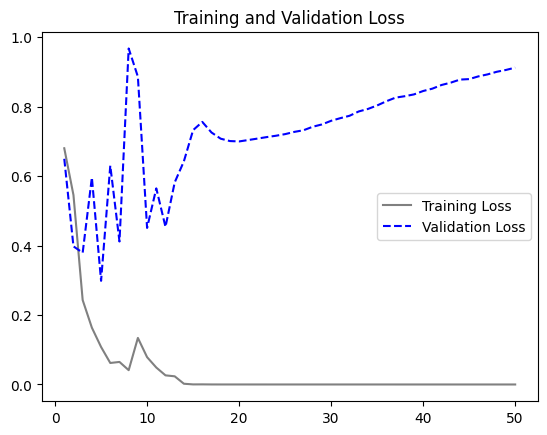

In [252]:
accuracy = Model_1.history["accuracy"]
val_accuracy = Model_1.history["val_accuracy"]

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_1 on test set**

In [253]:
test_model = keras.models.load_model("model1.keras")
Model1_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

4/4 [==============================] - 0s 16ms/step - loss: 0.7067 - accuracy: 0.8700
Loss: 0.707
Accuracy: 0.870


### **Using Measures to Avoid Overfitting - Using Data Auguentation**

In [254]:
# To deprecate warnings that are making the output look clumsy
import logging
logging.getLogger('tensorflow').disabled = True

In [255]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
        layers.RandomRotation(factor=0.05),
    ]
)

### **Looking at the augmented images**

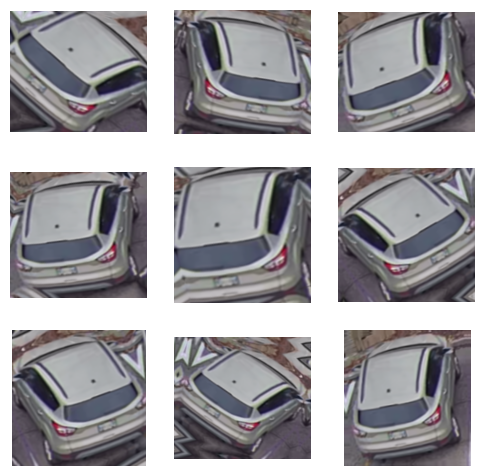

In [256]:
plt.figure(figsize=(6, 6))
for images, _ in train_dataset.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

# **Model-2 MaxPooling Operation with Increase in filters from 32 to 512 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5**

In [257]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_44 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_230 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_186 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_231 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_187 (MaxPooli  (None, 54, 54, 64)       0         
 ng2D)                                                    

### **Training The model**

In [258]:
# Compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Fitting/Running the Model
Model_2 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/50
8/8 [==============================] - 3s 102ms/step - loss: 0.7085 - accuracy: 0.5360 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 1s 77ms/step - loss: 0.6452 - accuracy: 0.5320 - val_loss: 0.6168 - val_accuracy: 0.5700
Epoch 3/50
8/8 [==============================] - 1s 78ms/step - loss: 0.3964 - accuracy: 0.8160 - val_loss: 0.3315 - val_accuracy: 0.9100
Epoch 4/50
8/8 [==============================] - 1s 77ms/step - loss: 0.1980 - accuracy: 0.9400 - val_loss: 0.3093 - val_accuracy: 0.8800
Epoch 5/50
8/8 [==============================] - 1s 68ms/step - loss: 0.0988 - accuracy: 0.9680 - val_loss: 0.4365 - val_accuracy: 0.8800
Epoch 6/50
8/8 [==============================] - 1s 76ms/step - loss: 0.0967 - accuracy: 0.9720 - val_loss: 0.2871 - val_accuracy: 0.9200
Epoch 7/50
8/8 [==============================] - 1s 77ms/step - loss: 0.1137 - accuracy: 0.9600 - val_loss: 0.2313 - val_accuracy: 0.9200
Epoch 8/50
8/8 [==========

### **Looking at the visuals of the Training and Validation Accuracy/Loss**

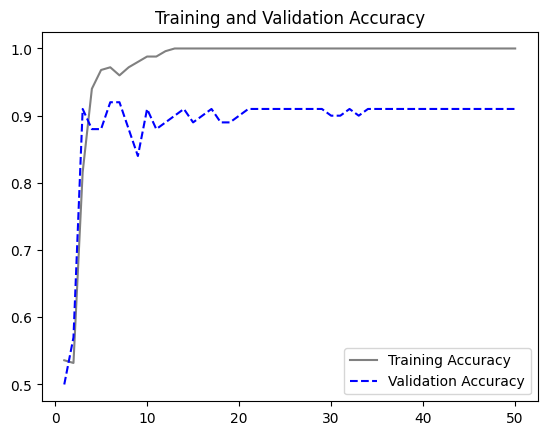

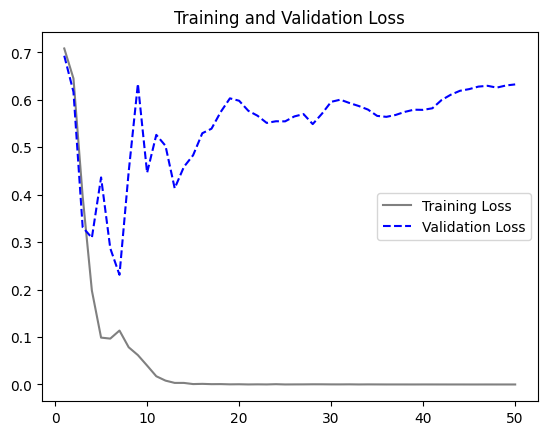

In [259]:
accuracy = Model_2.history["accuracy"]
val_accuracy = Model_2.history["val_accuracy"]

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_2 on the test set**

In [260]:
test_model = keras.models.load_model("model2.keras")
Model2_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

4/4 [==============================] - 0s 16ms/step - loss: 0.5466 - accuracy: 0.8700
Loss: 0.547
Accuracy: 0.870


# **Model - 3 MaxPooling Operation with Increase in filters from 32 to 512 in 6 Input Layers with the use of Augmented Images and Dropout rate of 0.2**

In [261]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_45 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_235 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_190 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_236 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_191 (MaxPooli  (None, 54, 54, 64)       0         
 ng2D)                                                    

### **Training the model 3**

In [262]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ["accuracy"])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath= "model3.keras",
            save_best_only= True,
            monitor= "val_loss")


# Model Fit
Model_3 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/50
8/8 [==============================] - 3s 111ms/step - loss: 0.6899 - accuracy: 0.5480 - val_loss: 0.6544 - val_accuracy: 0.5200
Epoch 2/50
8/8 [==============================] - 1s 82ms/step - loss: 0.5462 - accuracy: 0.6960 - val_loss: 0.5063 - val_accuracy: 0.7600
Epoch 3/50
8/8 [==============================] - 1s 82ms/step - loss: 0.3601 - accuracy: 0.8680 - val_loss: 0.4559 - val_accuracy: 0.7700
Epoch 4/50
8/8 [==============================] - 1s 81ms/step - loss: 0.2302 - accuracy: 0.9040 - val_loss: 0.3100 - val_accuracy: 0.9000
Epoch 5/50
8/8 [==============================] - 1s 69ms/step - loss: 0.2412 - accuracy: 0.8960 - val_loss: 0.4121 - val_accuracy: 0.8600
Epoch 6/50
8/8 [==============================] - 1s 69ms/step - loss: 0.1148 - accuracy: 0.9560 - val_loss: 0.4035 - val_accuracy: 0.8600
Epoch 7/50
8/8 [==============================] - 1s 69ms/step - loss: 0.0604 - accuracy: 0.9720 - val_loss: 0.3537 - val_accuracy: 0.8900
Epoch 8/50
8/8 [==========

### **Visualizing the Training and Validation Accuracy/Loss 2**

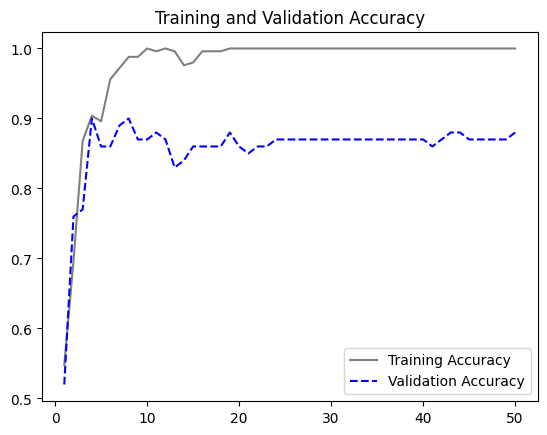

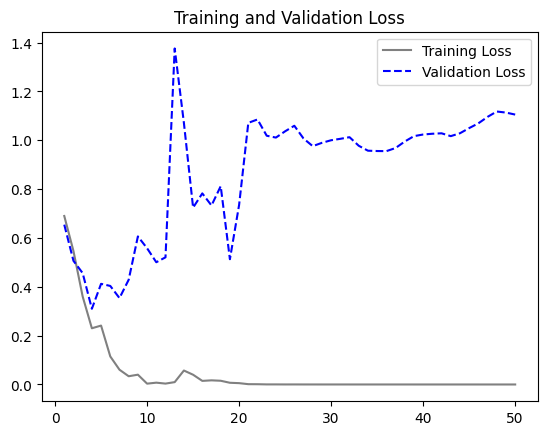

In [263]:
accuracy = Model_3.history["accuracy"]
val_accuracy = Model_3.history["val_accuracy"]

loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_2 on the test set**

In [264]:
best_model = keras.models.load_model("model3.keras")
Model3_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

4/4 [==============================] - 0s 16ms/step - loss: 0.4037 - accuracy: 0.8400
Loss: 0.404
Accuracy: 0.840


# **Model - 4 MaxPooling Operation with Increase in filters from 64 to 1024 in 5 Input Layers with the use of Augmented Images and Dropout rate of 0.2**

In [265]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_46 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_241 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_195 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_242 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_196 (MaxPooli  (None, 54, 54, 64)       0         
 ng2D)                                                    

### **Training The model**

In [266]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_4 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
8/8 [==============================] - 4s 135ms/step - loss: 0.7132 - accuracy: 0.5080 - val_loss: 0.6741 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 1s 102ms/step - loss: 0.5754 - accuracy: 0.7000 - val_loss: 0.5510 - val_accuracy: 0.6400
Epoch 3/50
8/8 [==============================] - 1s 106ms/step - loss: 0.3142 - accuracy: 0.8680 - val_loss: 0.3578 - val_accuracy: 0.8500
Epoch 4/50
8/8 [==============================] - 1s 77ms/step - loss: 0.1816 - accuracy: 0.9320 - val_loss: 0.5189 - val_accuracy: 0.8500
Epoch 5/50
8/8 [==============================] - 1s 78ms/step - loss: 0.1944 - accuracy: 0.9280 - val_loss: 0.5267 - val_accuracy: 0.8300
Epoch 6/50
8/8 [==============================] - 1s 78ms/step - loss: 0.0619 - accuracy: 0.9760 - val_loss: 0.5087 - val_accuracy: 0.8700
Epoch 7/50
8/8 [==============================] - 1s 77ms/step - loss: 0.0231 - accuracy: 0.9880 - val_loss: 0.7284 - val_accuracy: 0.8400
Epoch 8/50
8/8 [========

### **Visualizing the Training and Validation Accuracy/Loss 2**

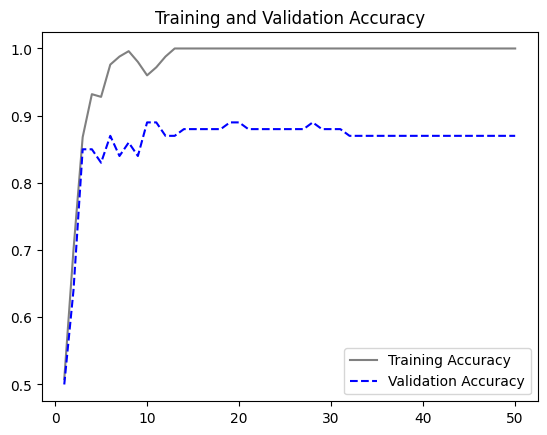

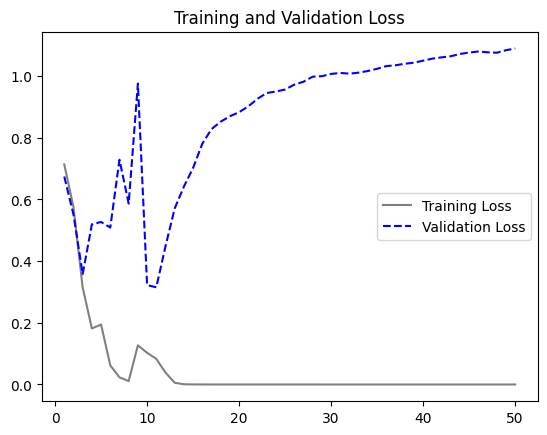

In [267]:
accuracy = Model_4.history["accuracy"]
val_accuracy = Model_4.history["val_accuracy"]

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_4 on the test set**

In [268]:
best_model = keras.models.load_model("model4.keras")
Model4_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

4/4 [==============================] - 0s 19ms/step - loss: 0.9672 - accuracy: 0.8500
Loss: 0.967
Accuracy: 0.850


# **Model - 5 MaxPooling Operation with Increase in filters from 64 to 1024 in 5 Input Layers with the use of Augmented Images and Dropout rate of 0.6**

In [269]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_47 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_247 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_200 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_248 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_201 (MaxPooli  (None, 54, 54, 64)       0         
 ng2D)                                                    

### **Training The model**

In [270]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_5 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
8/8 [==============================] - 4s 132ms/step - loss: 0.6939 - accuracy: 0.5480 - val_loss: 0.6420 - val_accuracy: 0.5100
Epoch 2/50
8/8 [==============================] - 1s 107ms/step - loss: 0.4271 - accuracy: 0.8240 - val_loss: 0.3105 - val_accuracy: 0.8800
Epoch 3/50
8/8 [==============================] - 1s 104ms/step - loss: 0.2098 - accuracy: 0.9320 - val_loss: 0.2515 - val_accuracy: 0.9100
Epoch 4/50
8/8 [==============================] - 1s 78ms/step - loss: 0.1002 - accuracy: 0.9720 - val_loss: 0.3394 - val_accuracy: 0.9100
Epoch 5/50
8/8 [==============================] - 1s 79ms/step - loss: 0.1905 - accuracy: 0.9360 - val_loss: 0.7424 - val_accuracy: 0.7100
Epoch 6/50
8/8 [==============================] - 1s 77ms/step - loss: 0.2264 - accuracy: 0.9120 - val_loss: 0.5662 - val_accuracy: 0.8100
Epoch 7/50
8/8 [==============================] - 1s 79ms/step - loss: 0.1495 - accuracy: 0.9520 - val_loss: 0.3289 - val_accuracy: 0.8800
Epoch 8/50
8/8 [========

### **Visualizing the Training and Validation Accuracy/Loss 2**

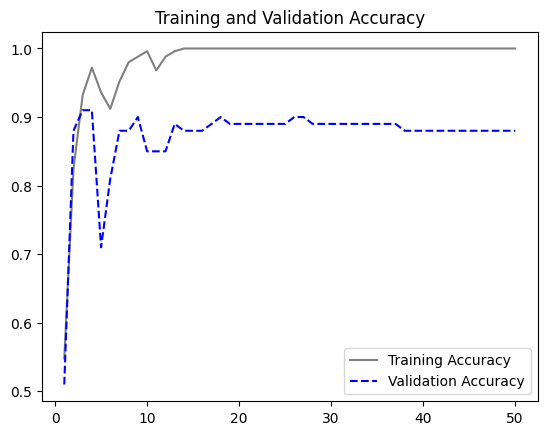

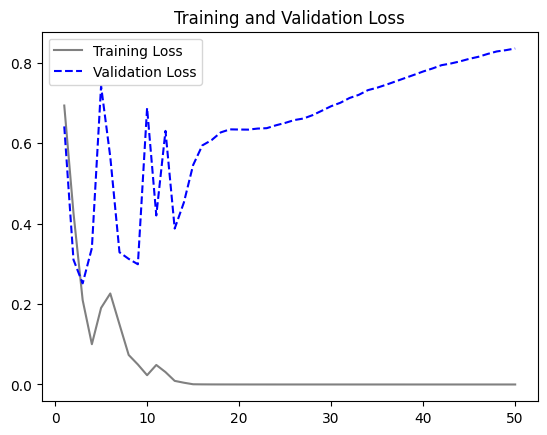

In [271]:
accuracy = Model_5.history["accuracy"]
val_accuracy = Model_5.history["val_accuracy"]

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### **Evaluating the performance of Model_2 on the test set**

In [272]:
test_model = keras.models.load_model("model5.keras")
Model5_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

4/4 [==============================] - 0s 18ms/step - loss: 0.3907 - accuracy: 0.8700
Loss: 0.391
Accuracy: 0.870


In [273]:
data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

In [274]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2, padding="same")(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_48 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_253 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_205 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_254 (Conv2D)         (None, 109, 109, 64)      18496     
                                                          

In [275]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model6.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_6 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
8/8 [==============================] - 3s 112ms/step - loss: 0.7520 - accuracy: 0.4720 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 1s 85ms/step - loss: 0.6985 - accuracy: 0.5000 - val_loss: 0.6801 - val_accuracy: 0.5000
Epoch 3/50
8/8 [==============================] - 1s 85ms/step - loss: 0.6550 - accuracy: 0.6440 - val_loss: 0.6526 - val_accuracy: 0.5000
Epoch 4/50
8/8 [==============================] - 1s 85ms/step - loss: 0.5759 - accuracy: 0.6840 - val_loss: 0.5684 - val_accuracy: 0.7200
Epoch 5/50
8/8 [==============================] - 1s 86ms/step - loss: 0.4317 - accuracy: 0.8560 - val_loss: 0.4465 - val_accuracy: 0.8400
Epoch 6/50
8/8 [==============================] - 1s 75ms/step - loss: 0.3829 - accuracy: 0.8560 - val_loss: 0.4791 - val_accuracy: 0.8200
Epoch 7/50
8/8 [==============================] - 1s 75ms/step - loss: 0.2580 - accuracy: 0.8920 - val_loss: 0.8321 - val_accuracy: 0.7500
Epoch 8/50
8/8 [==========

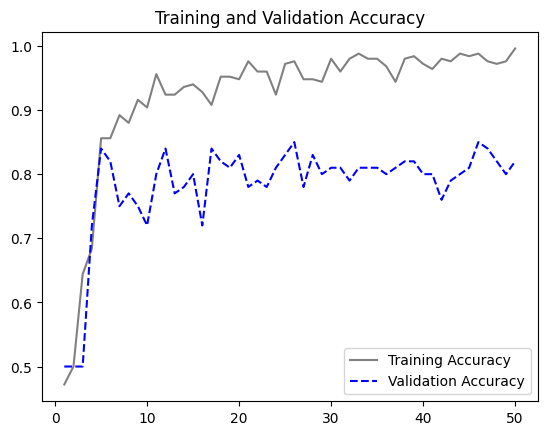

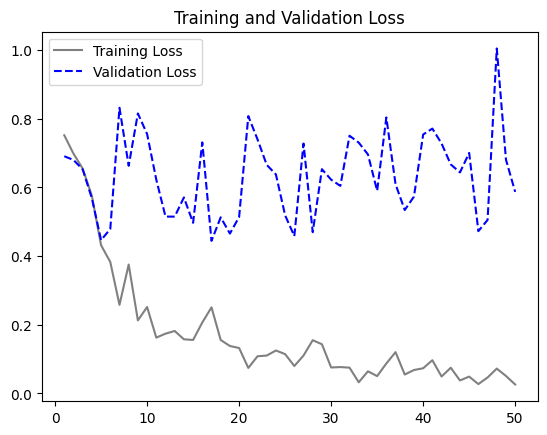

In [276]:
accuracy = Model_6.history["accuracy"]
val_accuracy = Model_6.history["val_accuracy"]

loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [277]:
best_model = keras.models.load_model("model6.keras")
Model6_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model6_Results[0]:.3f}')
print(f'Accuracy: {Model6_Results[1]:.3f}')

4/4 [==============================] - 0s 17ms/step - loss: 0.6187 - accuracy: 0.7400
Loss: 0.619
Accuracy: 0.740


In [278]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [279]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model7.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_7 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
8/8 [==============================] - 4s 109ms/step - loss: 0.6824 - accuracy: 0.5680 - val_loss: 1.0536 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 1s 83ms/step - loss: 0.7379 - accuracy: 0.6200 - val_loss: 0.6859 - val_accuracy: 0.6800
Epoch 3/50
8/8 [==============================] - 1s 83ms/step - loss: 0.6571 - accuracy: 0.7120 - val_loss: 0.6040 - val_accuracy: 0.7200
Epoch 4/50
8/8 [==============================] - 1s 82ms/step - loss: 0.4827 - accuracy: 0.7760 - val_loss: 0.4702 - val_accuracy: 0.7600
Epoch 5/50
8/8 [==============================] - 1s 73ms/step - loss: 0.3692 - accuracy: 0.8160 - val_loss: 0.4837 - val_accuracy: 0.8000
Epoch 6/50
8/8 [==============================] - 1s 73ms/step - loss: 0.2687 - accuracy: 0.8920 - val_loss: 0.4820 - val_accuracy: 0.8300
Epoch 7/50
8/8 [==============================] - 1s 72ms/step - loss: 0.2615 - accuracy: 0.9040 - val_loss: 0.5805 - val_accuracy: 0.7800
Epoch 8/50
8/8 [==========

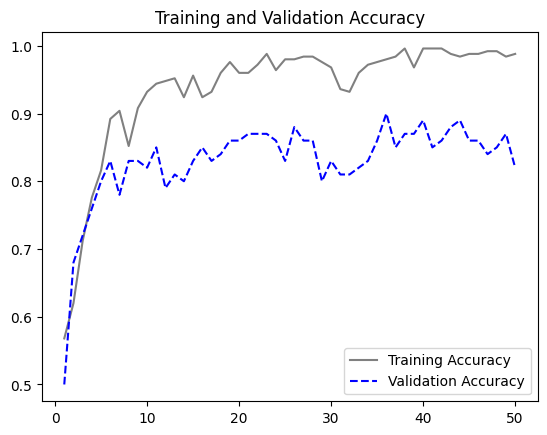

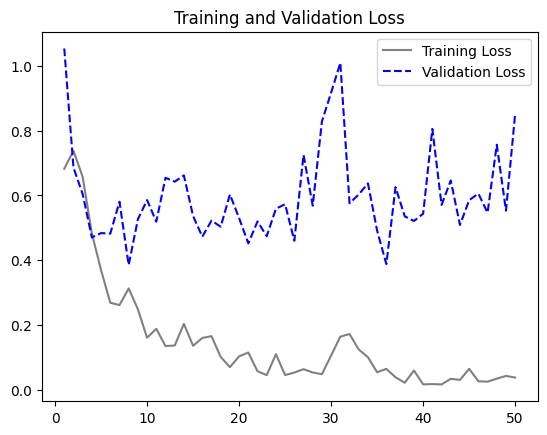

In [280]:
accuracy = Model_7.history["accuracy"]
val_accuracy = Model_7.history["val_accuracy"]

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [281]:
best_model = keras.models.load_model("model7.keras")
Model7_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model7_Results[0]:.3f}')
print(f'Accuracy: {Model7_Results[1]:.3f}')

4/4 [==============================] - 0s 16ms/step - loss: 0.5751 - accuracy: 0.8100
Loss: 0.575
Accuracy: 0.810


# **Pre Trained Model: Build a model on top of VGG16**

In [282]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [283]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

In [284]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [285]:
#extracting VGG 16 features and Labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 21ms/step


In [286]:
train_features.shape

(250, 7, 7, 512)

In [287]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

In [288]:
# Before Freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [289]:
# After Freezing
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [290]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [291]:
# Data Augmentation -Adding a data augmentation stage to provide augmented training samples and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [292]:
# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath= "vgg_model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Model Fit
VGG_Model_2 = model.fit(
              train_dataset,
              epochs= 50,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/50
8/8 [==============================] - 4s 264ms/step - loss: 53.0806 - accuracy: 0.8200 - val_loss: 19.6988 - val_accuracy: 0.9000
Epoch 2/50
8/8 [==============================] - 2s 231ms/step - loss: 1.1026 - accuracy: 0.9880 - val_loss: 14.2198 - val_accuracy: 0.8700
Epoch 3/50
8/8 [==============================] - 2s 199ms/step - loss: 0.7204 - accuracy: 0.9960 - val_loss: 17.1299 - val_accuracy: 0.8900
Epoch 4/50
8/8 [==============================] - 2s 200ms/step - loss: 2.1112 - accuracy: 0.9720 - val_loss: 16.3484 - val_accuracy: 0.9200
Epoch 5/50
8/8 [==============================] - 2s 235ms/step - loss: 1.7340 - accuracy: 0.9920 - val_loss: 10.8744 - val_accuracy: 0.9200
Epoch 6/50
8/8 [==============================] - 2s 237ms/step - loss: 1.4961 - accuracy: 0.9880 - val_loss: 5.9453 - val_accuracy: 0.9300
Epoch 7/50
8/8 [==============================] - 2s 202ms/step - loss: 9.3029e-22 - accuracy: 1.0000 - val_loss: 5.9453 - val_accuracy: 0.9300
Epoch 8/50

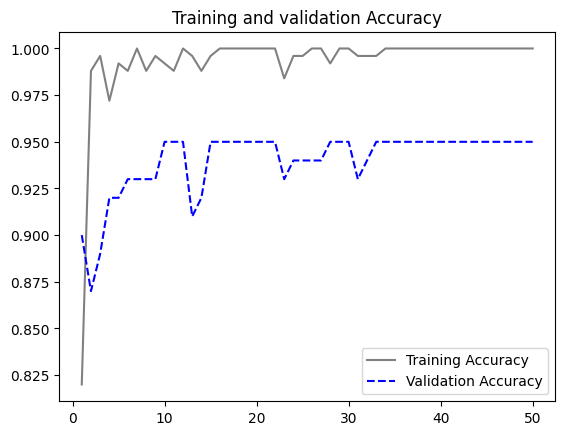

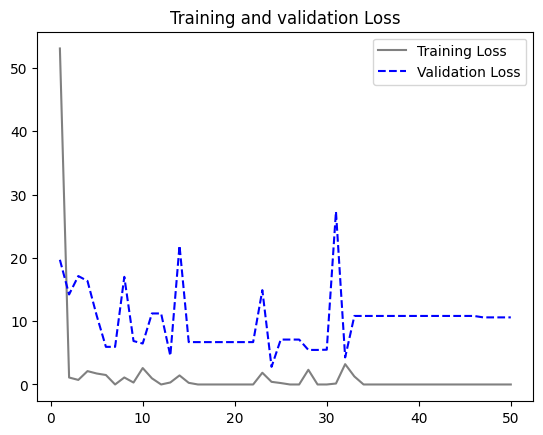

In [293]:
acc = VGG_Model_2.history["accuracy"]
val_acc = VGG_Model_2.history["val_accuracy"]

loss = VGG_Model_2.history["loss"]
val_loss = VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [294]:
best_model = keras.models.load_model("vgg_model2.keras")
VGG_Model_2_Results= best_model.evaluate(test_dataset)
print(f'Loss: {VGG_Model_2_Results[0]:.3f}')
print(f'Accuracy: {VGG_Model_2_Results[1]:.3f}')

4/4 [==============================] - 1s 96ms/step - loss: 7.7084 - accuracy: 0.9300
Loss: 7.708
Accuracy: 0.930


In [295]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [296]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


callbacks = ModelCheckpoint(
            filepath="fine_tuning_vgg_model2.keras",
            save_best_only=True,
            monitor="val_loss")


FineTuned_VGG_Model_2 = model.fit(
                        train_dataset,
                        epochs=30,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/30
8/8 [==============================] - 4s 291ms/step - loss: 2.2678e-34 - accuracy: 1.0000 - val_loss: 10.6001 - val_accuracy: 0.9500
Epoch 2/30
8/8 [==============================] - 2s 264ms/step - loss: 0.7209 - accuracy: 0.9960 - val_loss: 4.1568 - val_accuracy: 0.9500
Epoch 3/30
8/8 [==============================] - 2s 219ms/step - loss: 2.1105e-05 - accuracy: 1.0000 - val_loss: 4.4132 - val_accuracy: 0.9600
Epoch 4/30
8/8 [==============================] - 2s 220ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.4132 - val_accuracy: 0.9600
Epoch 5/30
8/8 [==============================] - 2s 219ms/step - loss: 1.3654e-31 - accuracy: 1.0000 - val_loss: 4.4132 - val_accuracy: 0.9600
Epoch 6/30
8/8 [==============================] - 2s 219ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.4132 - val_accuracy: 0.9600
Epoch 7/30
8/8 [==============================] - 2s 218ms/step - loss: 7.5654e-30 - accuracy: 1.0000 - val_loss: 4.4132 - val_accuracy: 0.

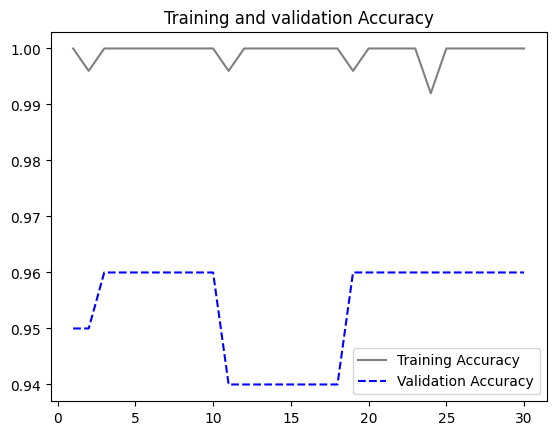

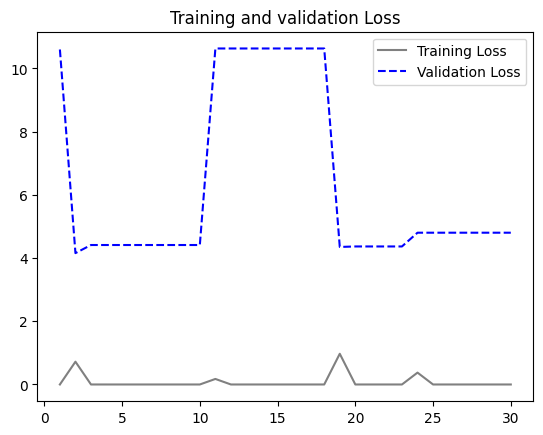

In [297]:
acc = FineTuned_VGG_Model_2.history["accuracy"]
val_acc = FineTuned_VGG_Model_2.history["val_accuracy"]

loss = FineTuned_VGG_Model_2.history["loss"]
val_loss = FineTuned_VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [298]:
best_model = keras.models.load_model("fine_tuning_vgg_model2.keras")
FineTuned_VGG_Model_2_Results = best_model.evaluate(test_dataset)
print(f"Loss: {FineTuned_VGG_Model_2_Results[0]:.3f}")
print(f"Accuracy: {FineTuned_VGG_Model_2_Results[1]:.3f}")

4/4 [==============================] - 1s 96ms/step - loss: 6.7237 - accuracy: 0.9400
Loss: 6.724
Accuracy: 0.940
